In [328]:
import os
import requests
from dotenv import load_dotenv
import pandas as pd
import pycountry
import pypopulation
from geojson import FeatureCollection, dump
import numpy as np
import xlrd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, box
from shapely.ops import unary_union
from shapely import union_all

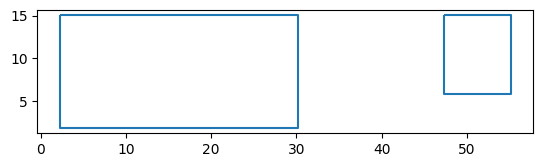

In [329]:
poly1 = Polygon([(47.270238,5.866315), (47.270238,15.041832),(55.1286491,15.041832),(55.1286491,5.866315)])
poly2 = Polygon([(2.270238,1.866315), (2.270238,15.041832),(30.1286491,15.041832),(30.1286491,1.866315)])
polys = [poly1,poly2]

mergedPolys = unary_union(polys)

gpd.GeoSeries([mergedPolys]).boundary.plot()
plt.show()

In [330]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
continents = world.dissolve(by='continent', aggfunc='sum')

/home/jstet/Code/Uni/Basel_Convention_Scraper/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [331]:
def func(x):
    return x.centroid

continents["centroid"] = continents.apply(lambda x: func(x["geometry"]), axis=1)

In [332]:
continents

,geometry,pop_est,gdp_md_est,centroid
continent,,,,
Africa,"MULTIPOLYGON (((-11.43878 6.78592, -11.70819 6...",1.306370e+09,2455514,POINT (18.20682 6.45017)
Antarctica,"MULTIPOLYGON (((-61.13898 -79.98137, -60.61012...",4.490000e+03,898,POINT (20.57100 -80.49198)
Asia,"MULTIPOLYGON (((48.67923 14.00320, 48.23895 13...",4.550277e+09,32725478,POINT (84.58722 32.27746)
Europe,"MULTIPOLYGON (((-53.55484 2.33490, -53.77852 2...",7.454125e+08,21587850,POINT (78.61808 60.00093)
North America,"MULTIPOLYGON (((-155.22217 19.23972, -155.5421...",5.837560e+08,25075988,POINT (-92.17997 56.61537)
Oceania,"MULTIPOLYGON (((147.91405 -43.21152, 147.56456...",4.120487e+07,1647113,POINT (136.76574 -25.31884)
Seven seas (open ocean),"POLYGON ((68.93500 -48.62500, 69.58000 -48.940...",1.400000e+02,16,POINT (69.53158 -49.30645)
South America,"MULTIPOLYGON (((-68.63999 -55.58002, -69.23210...",4.270667e+08,3852015,POINT (-60.87852 -15.47992)


## Geocoding
Assigning countries coordinates

In [333]:
load_dotenv()
TOKEN=os.getenv("MAPBOX_TOKEN")
df = pd.read_csv("../output/processed/flows.csv") # ../output/processed/
origins = list(df.origin.unique())
destinations = list(df.destination.unique())

In [334]:
in_first = set(origins)
in_second = set(destinations)
in_second_but_not_in_first = in_second - in_first
countries = origins + list(in_second_but_not_in_first)

In [335]:
df = pd.DataFrame({"country":countries})

In [336]:
headers = {'Accept': 'application/json'}
lst = []
for i in countries:
    obj = {}
    obj["type"]="Feature"
    obj["properties"]={"name": pycountry.countries.get(alpha_2=i).name}
    pop = pypopulation.get_population_a2(i)
    url = f"https://api.mapbox.com/geocoding/v5/mapbox.places/{i}.json?&types=country&access_token={TOKEN}"
    r = requests.get(url)
    jason = r.json()
    obj["properties"]["code"] = i.lower()
    coords = jason["features"][0]["center"]
    bbox = jason["features"][0]["bbox"]
    obj["geometry"] = {"type":"Point", "coordinates": coords}
    lst.append(obj)
    df.loc[df["country"] == i, "lat"] = coords[1]
    df.loc[df["country"] == i, "lon"] = coords[0]
    df.loc[df["country"] == i, "name"] = obj["properties"]["name"]
    df.loc[df["country"] == i, "population"] = pop
    df.loc[df["country"] == i, "bbox"] = str(bbox)
    if i in destinations and not i in origins:
        df.loc[df["country"] == i, "destination_only"] = True
    else:
        df.loc[df["country"] == i, "destination_only"] = False

In [337]:
with open('../output/processed/countries.geojson', 'w') as f:
    dump(FeatureCollection(lst), f)

In [338]:
df['population'] = df['population'].fillna(0).astype(int)

In [339]:
# filling one country manually
df.loc[df[df["name"]=="Saint Barthélemy"].index, 'population'] = 10457
df = df.astype({'population':'str'})

## Clustering


In [340]:
# https://unstats.un.org/unsd/methodology/m49/overview/
regions = pd.read_excel("regions.xls")

In [341]:
def func(x):
    iso3 = pycountry.countries.get(alpha_2=x).alpha_3
    result = int(regions[regions["ISO-alpha3 Code"] == iso3]["Sub-region Code"].values[0])
    return result

df["sub_region_code"] = df.apply(lambda x: func(x["country"]), axis=1)

def func(x):
    iso3 = pycountry.countries.get(alpha_2=x).alpha_3
    result = regions[regions["ISO-alpha3 Code"] == iso3]["Sub-region Name"].values[0]
    return result

df["sub_region_name"] = df.apply(lambda x: func(x["country"]), axis=1)

def func(x):
    iso3 = pycountry.countries.get(alpha_2=x).alpha_3
    result = int(regions[regions["ISO-alpha3 Code"] == iso3]["Region Code"].values[0])
    return result

df["region_code"] = df.apply(lambda x: func(x["country"]), axis=1)

def func(x):
    iso3 = pycountry.countries.get(alpha_2=x).alpha_3
    result = regions[regions["ISO-alpha3 Code"] == iso3]["Region Name"].values[0]
    return result

df["region_name"] = df.apply(lambda x: func(x["country"]), axis=1)



In [342]:
def func(x):
    bbox = (eval(x)[1],eval(x)[0],eval(x)[3],eval(x)[2])
    return box(*bbox, ccw=True)
df["polygon"] = df.apply(lambda x: func(x["bbox"]), axis=1)

In [343]:
def centroids(typ):
    obj = {}
    for i in list(df[f"{typ}_name"].unique()):
        polygons = list(df[df[f"{typ}_name"] == i]["polygon"])
        u = union_all(polygons)
        obj[i] = u.centroid
    df[f"{typ}_lat"] = df.apply(lambda x: obj[x[f"{typ}_name"]].xy[0][0], axis=1)
    df[f"{typ}_lon"] = df.apply(lambda x: obj[x[f"{typ}_name"]].xy[1][0], axis=1)

<Axes: >

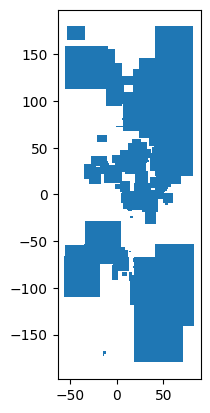

In [344]:
gpd.GeoSeries(list(df[f"polygon"].unique())).plot()

In [345]:
# def centroids(typ):
#     obj = {}
#     for i in list(df[f"{typ}_name"].unique()):
#         lats = df[df[f"{typ}_name"] == i]["lat"]
#         lons = df[df[f"{typ}_name"] == i]["lon"]
#         lat = sum(lats)/len(lats)
#         lon = sum(lons)/len(lons)
#         obj[i] = [lat,lon]
#
#     df[f"{typ}_lat"] = df.apply(lambda x: obj[x[f"{typ}_name"]][0], axis=1)
#     df[f"{typ}_lon"] = df.apply(lambda x: obj[x[f"{typ}_name"]][1], axis=1)

In [346]:
def centroids(typ):
    obj = {}
    for i in list(df[f"{typ}_name"].unique()):
        polygons = list(df[df[f"{typ}_name"] == i]["polygon"])
        u = union_all(polygons)
        obj[i] = u.centroid
    df[f"{typ}_lat"] = df.apply(lambda x: obj[x[f"{typ}_name"]].xy[0][0], axis=1)
    df[f"{typ}_lon"] = df.apply(lambda x: obj[x[f"{typ}_name"]].xy[1][0], axis=1)

df["region2_name"] = df["region_name"]
df.loc[df["name"].isin(["Samoa","American Samoa"]), "region2_name"] = 0

In [347]:
centroids("region2")
centroids("sub_region")

In [348]:
df.drop('region2_name', axis = 1, inplace=True)
df.drop('polygon', axis = 1, inplace=True)
df.drop('bbox', axis = 1, inplace=True)
df.rename(columns={'region2_lat': "region_lat", "region2_lon": "region_lon" }, inplace=True)
df

,country,lat,lon,name,population,destination_only,sub_region_code,sub_region_name,region_code,region_name,region_lat,region_lon,sub_region_lat,sub_region_lon
0,ad,42.548654,1.576766,Andorra,77142,False,39,Southern Europe,150,Europe,51.115894,73.175181,31.361422,-38.216696
1,ae,1.612130,10.525771,United Arab Emirates,9770529,False,145,Western Asia,142,Asia,36.634306,-21.982547,43.308236,-105.575196
2,af,33.838806,66.026471,Afghanistan,38041754,False,34,Southern Asia,142,Asia,36.634306,-21.982547,23.045643,78.599963
3,al,28.163240,2.632388,Albania,2854191,False,39,Southern Europe,150,Europe,51.115894,73.175181,31.361422,-38.216696
4,am,39.381266,-97.922211,Armenia,2957731,False,145,Western Asia,142,Asia,36.634306,-21.982547,43.308236,-105.575196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,gm,13.444526,-15.912854,Gambia,2347706,True,202,Sub-Saharan Africa,2,Africa,4.435222,23.911857,-2.074168,20.234168
151,sa,23.384784,44.652426,Saudi Arabia,34268528,True,145,Western Asia,142,Asia,36.634306,-21.982547,43.308236,-105.575196
152,ug,1.279964,32.386218,Uganda,44269594,True,202,Sub-Saharan Africa,2,Africa,4.435222,23.911857,-2.074168,20.234168
153,tm,39.122285,59.384377,Turkmenistan,5942089,True,143,Central Asia,142,Asia,36.634306,-21.982547,46.414818,66.400259


In [349]:
df.loc[df["name"].isin(["Samoa","American Samoa"]), "region_lat"] = df.loc[df["name"] == "Australia"]["region_lat"].values[0]
df.loc[df["name"].isin(["Samoa","American Samoa"]), "region_lon"] = df.loc[df["name"] == "Australia"]["region_lon"].values[0]

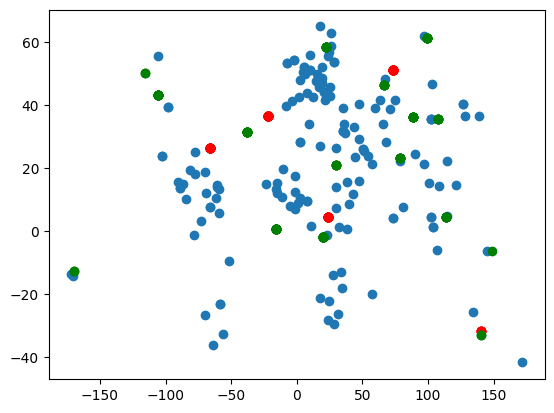

In [350]:
plt.scatter(df["lon"], df["lat"])
plt.scatter(df["region_lon"], df["region_lat"], c="red")
plt.scatter(df["sub_region_lon"], df["sub_region_lat"], c="green")
plt.show()

In [351]:
df.rename(columns={"country": "code"}, inplace=True)

In [352]:
df = df[["code","name","lat","lon","region_code","region_name","region_lat","region_lon","sub_region_code","sub_region_name", "sub_region_lat", "sub_region_lon","population","destination_only"]]
df

,code,name,lat,lon,region_code,region_name,region_lat,region_lon,sub_region_code,sub_region_name,sub_region_lat,sub_region_lon,population,destination_only
0,ad,Andorra,42.548654,1.576766,150,Europe,51.115894,73.175181,39,Southern Europe,31.361422,-38.216696,77142,False
1,ae,United Arab Emirates,1.612130,10.525771,142,Asia,36.634306,-21.982547,145,Western Asia,43.308236,-105.575196,9770529,False
2,af,Afghanistan,33.838806,66.026471,142,Asia,36.634306,-21.982547,34,Southern Asia,23.045643,78.599963,38041754,False
3,al,Albania,28.163240,2.632388,150,Europe,51.115894,73.175181,39,Southern Europe,31.361422,-38.216696,2854191,False
4,am,Armenia,39.381266,-97.922211,142,Asia,36.634306,-21.982547,145,Western Asia,43.308236,-105.575196,2957731,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,gm,Gambia,13.444526,-15.912854,2,Africa,4.435222,23.911857,202,Sub-Saharan Africa,-2.074168,20.234168,2347706,True
151,sa,Saudi Arabia,23.384784,44.652426,142,Asia,36.634306,-21.982547,145,Western Asia,43.308236,-105.575196,34268528,True
152,ug,Uganda,1.279964,32.386218,2,Africa,4.435222,23.911857,202,Sub-Saharan Africa,-2.074168,20.234168,44269594,True
153,tm,Turkmenistan,39.122285,59.384377,142,Asia,36.634306,-21.982547,143,Central Asia,46.414818,66.400259,5942089,True


In [354]:
df.to_csv("../output/processed/countries.csv", index=False)